In [556]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [557]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ALL_TARGETS_OUTPUT_DIRECTORY = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets"
)

ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

In [558]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# map uniprot id's to fasta
def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""

    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()

            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict


protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assay_list["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

In [559]:
# def export_fasta(output_path, df):
#     with open(output_path, "w") as output_file:
#         for index, row in df.iterrows():
#             output_file.write(f'>{row["UniProt ID"]}\n')
#             output_file.write(f'{row["Sequence"]}\n')


# export_fasta(ALL_FASTA_OUTPUT_PATH, assay_list)

# deeptmhmm = biolib.load("DTU/DeepTMHMM")


# def tmhmm_localization(targets, output_directory):
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
#     os.chdir(output_directory)

#     with open("query.fasta", "w") as fasta_file:
#         for _, row in targets.iterrows():
#             sequence = row["Sequence"]
#             uniprot_id = row["UniProt ID"]
#             fasta_line = f">{uniprot_id}\n{sequence}\n"
#             fasta_file.write(fasta_line)
#         biolib.utils.STREAM_STDOUT = True  # Stream progress from app in real time
#         deeptmhmm_job = deeptmhmm.cli(
#             args="--fasta query.fasta", machine="local"
#         )  # Blocks until done
#         deeptmhmm_job.save_files(output_directory)  # Saves all results to `result` dir


# tmhmm_localization(assay_list, ALL_TARGETS_OUTPUT_DIRECTORY)

In [560]:
# Path to your GFF3 file
gff_file_path = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets\\TMRs.gff3"
)


# Read lines from the GFF3 file
with open(gff_file_path, "r") as gff_file:
    gff_lines = gff_file.readlines()

# Create lists to store data
uniprot_ids = []
region_locations = []
region_starts = []
region_ends = []

# Process each line in the GFF file
for line in gff_lines:
    # Skip lines starting with "//"
    if not line.startswith("//"):
        # Split the line by tabs
        columns = line.strip().split("\t")

        # Ensure that the line has enough columns
        if len(columns) >= 4:
            # Extract information from the columns
            uniprot_id = columns[0]
            region_location = columns[1]
            region_start = int(columns[2])  # Assuming these are integer values
            region_end = int(columns[3])  # Assuming these are integer values

            uniprot_ids.append(uniprot_id)
            region_locations.append(region_location)
            region_starts.append(region_start)
            region_ends.append(region_end)

# Create a DataFrame
data = {
    "UniProt ID": uniprot_ids,
    "Region Location": region_locations,
    "Region Start": region_starts,
    "Region End": region_ends,
}

tmhmm_df = pd.DataFrame(data)

In [561]:
tm_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "TMhelix"]
signal_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "signal"]
outside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "outside"]
inside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "inside"]

In [562]:
tm_tmhmm = tm_tmhmm.drop(columns=["Region Location"])
signal_tmhmm = signal_tmhmm.drop(columns=["Region Location"])
outside_tmhmm = outside_tmhmm.drop(columns=["Region Location"])
inside_tmhmm = inside_tmhmm.drop(columns=["Region Location"])

In [563]:
tm_tmhmm.rename(
    columns={
        "UniProt ID": "UniProt ID",
        "Region Start": "TM Region Start",
        "Region End": "TM Region End",
    },
    inplace=True,
)
signal_tmhmm.rename(
    columns={
        "UniProt ID": "UniProt ID",
        "Region Start": "Signal Region Start",
        "Region End": "Signal Region End",
    },
    inplace=True,
)
inside_tmhmm.rename(
    columns={
        "UniProt ID": "UniProt ID",
        "Region Start": "Inside Region Start",
        "Region End": "Inside Region End",
    },
    inplace=True,
)
outside_tmhmm.rename(
    columns={
        "UniProt ID": "UniProt ID",
        "Region Start": "Outside Region Start",
        "Region End": "Outside Region End",
    },
    inplace=True,
)

In [564]:
merged_df = pd.merge(tm_tmhmm, signal_tmhmm, on="UniProt ID", how="outer")
merged_df = pd.merge(merged_df, inside_tmhmm, on="UniProt ID", how="outer")
merged_df = pd.merge(merged_df, outside_tmhmm, on="UniProt ID", how="outer")

In [565]:
all_regions_uniprots = []

all_except_tm_uniprots = []
all_except_signal_uniprots = []
all_except_inside_uniprots = []
all_except_outside_uniprots = []

tm_signal_uniprots = []
tm_inside_uniprots = []
tm_outside_uniprots = []

signal_inside_uniprots = []
signal_outside_uniprots = []

inside_outside_uniprots = []

tm_only_uniprots = []
signal_only_uniprots = []
inside_only_uniprots = []
outside_only_uniprots = []

for index, row in merged_df.iterrows():
    if (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Signal Region Start",
                "Signal Region End",
                "Inside Region Start",
                "Inside Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        all_regions_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "Signal Region Start",
                "Signal Region End",
                "Inside Region Start",
                "Inside Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        all_except_tm_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Inside Region Start",
                "Inside Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        all_except_signal_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Signal Region Start",
                "Signal Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        all_except_inside_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Signal Region Start",
                "Signal Region End",
                "Inside Region Start",
                "Inside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        all_except_outside_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Signal Region Start",
                "Signal Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        tm_signal_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "TM Region Start",
                "TM Region End",
                "Inside Region Start",
                "Inside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        tm_inside_uniprots.append(row["UniProt ID"])
    elif (
        not row[["TM Region Start", "TM Region End", "Outside Region End"]]
        .isnull()
        .any()
    ):
        tm_outside_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "Signal Region Start",
                "Signal Region End",
                "Inside Region Start",
                "Inside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        signal_inside_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "Signal Region Start",
                "Signal Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        signal_outside_uniprots.append(row["UniProt ID"])
    elif (
        not row[
            [
                "Inside Region Start",
                "Inside Region End",
                "Outside Region Start",
                "Outside Region End",
            ]
        ]
        .isnull()
        .any()
    ):
        inside_outside_uniprots.append(row["UniProt ID"])
    elif not row[["TM Region Start", "TM Region End"]].isnull().any():
        tm_only_uniprots.append(row["UniProt ID"])
    elif not row[["Signal Region Start", "Signal Region End"]].isnull().any():
        signal_only_uniprots.append(row["UniProt ID"])
    elif not row[["Inside Region Start", "Inside Region End"]].isnull().any():
        inside_only_uniprots.append(row["UniProt ID"])
    elif not row[["Outside Region Start", "Outside Region End"]].isnull().any():
        outside_only_uniprots.append(row["UniProt ID"])

In [566]:
all_signal = set(
    all_regions_uniprots
    + all_except_tm_uniprots
    + all_except_inside_uniprots
    + all_except_outside_uniprots
    + tm_signal_uniprots
    + signal_inside_uniprots
    + signal_inside_uniprots
    + signal_only_uniprots
)

In [567]:
all_tm = set(
    all_regions_uniprots
    + all_except_inside_uniprots
    + all_except_outside_uniprots
    + all_except_signal_uniprots
    + tm_signal_uniprots
    + tm_inside_uniprots
    + tm_outside_uniprots
    + tm_only_uniprots
)

In [568]:
all_inside = set(
    all_regions_uniprots
    + all_except_tm_uniprots
    + all_except_signal_uniprots
    + all_except_outside_uniprots
    + tm_inside_uniprots
    + signal_inside_uniprots
    + inside_outside_uniprots
    + inside_only_uniprots
)

In [569]:
all_outside = set(
    all_regions_uniprots
    + all_except_tm_uniprots
    + all_except_signal_uniprots
    + all_except_outside_uniprots
    + tm_outside_uniprots
    + signal_outside_uniprots
    + inside_outside_uniprots
    + outside_only_uniprots
)

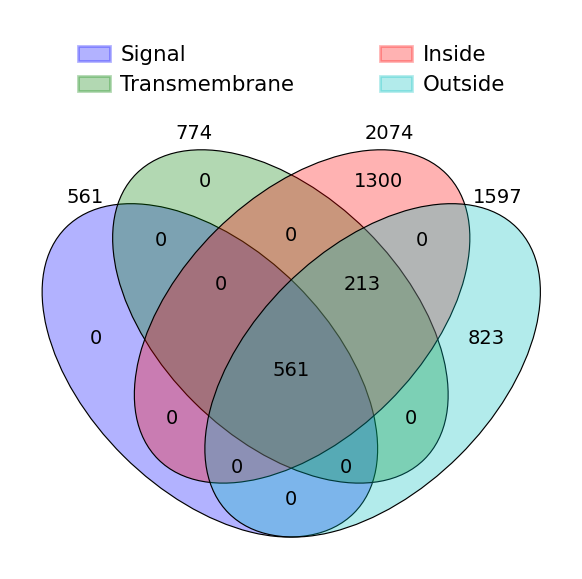

In [570]:
from venny4py.venny4py import *

# dict of sets
sets = {
    "Signal": all_signal,
    "Transmembrane": all_tm,
    "Inside": all_inside,
    "Outside": all_outside,
}

venny4py(sets=sets)

In [571]:
# # df_signal = df[df["Region Location"] == "signal"]
# # df_signal[~df_signal["UniProt ID"].isin(df_inside["UniProt ID"]) & ~df_signal["UniProt ID"].isin(df_TM["UniProt ID"]) & ~df_signal["UniProt ID"].isin(df_outside["UniProt ID"])]
# # The signal dataframe just provides information about a possible function of the outside/TM proteins
# # There are no UniProt IDs that only appear in the signal dataframe and not the TM/outside dataframes

# df_tm = tmhmm_df[tmhmm_df["Region Location"] == "TMhelix"]
# tm_uniprot_ids = df_tm["UniProt ID"].unique().tolist()
# olink_tm_target_count = len(tm_uniprot_ids)

# df_inside = tmhmm_df[tmhmm_df["Region Location"] == "inside"]
# # If there is a target appearing in both the TM and inside dataframe, it is only TM, it just also has an internal domain
# df_inside_filtered = df_inside[~df_inside["UniProt ID"].isin(df_tm["UniProt ID"])]
# inside_uniprot_ids = df_inside_filtered["UniProt ID"].unique().tolist()
# olink_internal_target_count = len(inside_uniprot_ids)


# df_outside = tmhmm_df[tmhmm_df["Region Location"] == "outside"]
# # If there is a target appearing in both the TM and outside dataframe, it is only TM, it just also has an external domain
# df_outside_filtered = df_outside[~df_outside["UniProt ID"].isin(df_tm["UniProt ID"])]
# outside_uniprot_ids = df_outside_filtered["UniProt ID"].unique().tolist()
# olink_external_target_count = len(outside_uniprot_ids)

In [572]:
# # Some assays may be dropped unnecessarily when filtering inside, outside, TM-- working on debugging
# olink_assays = list(df["UniProt ID"].unique())

# assay_list = pd.read_excel(ASSAY_LIST_PATH)

# not_tm_assays = assay_list.loc[
#     ~assay_list["UniProt ID"].isin(tm_uniprot_ids), "UniProt ID"
# ].tolist()
# missing_uniprot_ids = list(
#     set(not_tm_assays) - set(inside_uniprot_ids) - set(outside_uniprot_ids)
# )

# all_analyzed_assays = (tm_uniprot_ids) + (inside_uniprot_ids) + (outside_uniprot_ids)

# missing_olink_assays = list(set(olink_assays) - set(missing_uniprot_ids))

In [573]:
# total_count = (
#     olink_tm_target_count + olink_internal_target_count + olink_external_target_count
# )

# tm_percentage = (olink_tm_target_count / total_count) * 100
# internal_percentage = (olink_internal_target_count / total_count) * 100
# external_percentage = (olink_external_target_count / total_count) * 100


# # Labels and values for the pie chart
# labels = ["TM Targets", "Internal Targets", "External Targets"]
# sizes = [tm_percentage, internal_percentage, external_percentage]

# # Colors for each section
# colors = ["lightblue", "lightcoral", "lightgreen"]

# # Create the pie chart
# plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)

# # Equal aspect ratio ensures that the pie chart is drawn as a circle.
# plt.axis("equal")

# # Display the pie chart
# plt.show()

In [574]:
# # # Check for overlapping UniProt IDs
# overlap_inside_signal = df_inside_filtered["UniProt ID"].isin(df_signal["UniProt ID"])
# overlap_inside_TM = df_inside_filtered["UniProt ID"].isin(df_TM["UniProt ID"])
# overlap_inside_outside = df_inside_filtered["UniProt ID"].isin(df_outside_filtered["UniProt ID"])

# overlap_outside_signal = df_outside_filtered["UniProt ID"].isin(df_signal["UniProt ID"])
# overlap_outside_TM = df_outside_filtered["UniProt ID"].isin(df_TM["UniProt ID"])

# overlap_signal_tm = df_tm_filtered["UniProt ID"].isin(df_signal["UniProt ID"])

# # Display the results
# print("Overlap between inside and signal:")
# print(df_inside_filtered[overlap_inside_signal])

# print("\nOverlap between inside and TM:")
# print(df_inside_filtered[overlap_inside_TM])

# print("\nOverlap between inside and outside:")
# print(df_inside_filtered[overlap_inside_outside])

# print("\nOverlap between outside and signal:")
# print(df_outside_filtered[overlap_outside_signal])

# print("\nOverlap between outside and TM:")
# print(df_outside_filtered[overlap_outside_TM])

# print("\nOverlap between signal and TM:")
# print(df_tm_filtered[overlap_signal_tm])

# # only overlap between outside_filtered and signal

In [575]:
# # Check UniProt IDs in df_outside_filtered against df_inside_filtered and df_tm
# overlap_outside_inside = df_outside_filtered["UniProt ID"].isin(df_inside_filtered["UniProt ID"])
# overlap_outside_tm = df_outside_filtered["UniProt ID"].isin(df_tm["UniProt ID"])

# # Check UniProt IDs in df_inside_filtered against df_outside_filtered and df_tm
# overlap_inside_outside = df_inside_filtered["UniProt ID"].isin(df_outside_filtered["UniProt ID"])
# overlap_inside_tm = df_inside_filtered["UniProt ID"].isin(df_tm["UniProt ID"])

# # Check UniProt IDs in df_tm against df_outside_filtered and df_inside_filtered
# overlap_tm_outside = df_tm["UniProt ID"].isin(df_outside_filtered["UniProt ID"])
# overlap_tm_inside = df_tm["UniProt ID"].isin(df_inside_filtered["UniProt ID"])

# # Display the results
# print("Overlap between df_outside_filtered and df_inside_filtered:")
# print(df_outside_filtered[overlap_outside_inside])

# print("\nOverlap between df_outside_filtered and df_tm:")
# print(df_outside_filtered[overlap_outside_tm])

# print("\nOverlap between df_inside_filtered and df_outside_filtered:")
# print(df_inside_filtered[overlap_inside_outside])

# print("\nOverlap between df_inside_filtered and df_tm:")
# print(df_inside_filtered[overlap_inside_tm])

# print("\nOverlap between df_tm and df_outside_filtered:")
# print(df_tm[overlap_tm_outside])

# print("\nOverlap between df_tm and df_inside_filtered:")
# print(df_tm[overlap_tm_inside])

In [576]:
# filter the dataframe to only include targets that are 3x enriched in cell type of interest
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)


fetal_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_fetal_1",
    "astrocytes_fetal_2",
    "astrocytes_fetal_3",
    "astrocytes_fetal_4",
    "astrocytes_fetal_5",
    "astrocytes_fetal_6",
]  # should this list be in the first cell at the top of the file? (same question applies for the mature astrocyte, endothelial, microglia, oligodendrocytes lists)
fetal_astrocytes = brain_rna_seq[fetal_astrocytes_cols]

mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
mature_astrocytes = brain_rna_seq[mature_astrocytes_cols]

endothelial_cols = ["gene_id", "id", "endothelial_1", "endothelial_2"]
endothelial = brain_rna_seq[endothelial_cols]

microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
microglia = brain_rna_seq[microglia_cols]

oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
oligodendrocytes = brain_rna_seq[oligodendrocyte_cols]

neurons_cols = ["gene_id", "id", "neurons_1"]
neurons = brain_rna_seq[neurons_cols]

not_mean_calc = ["gene_id", "id"]


def find_mean(row):
    row_series = pd.Series(row)
    return row_series.mean()


neurons["Mean"] = neurons.mean(axis=1, numeric_only=True)

oligodendrocytes["Mean"] = oligodendrocytes.mean(axis=1, numeric_only=True)

microglia["Mean"] = microglia.mean(axis=1, numeric_only=True)

endothelial["Mean"] = endothelial.mean(axis=1, numeric_only=True)

mature_astrocytes["Mean"] = mature_astrocytes.mean(axis=1, numeric_only=True)

fetal_astrocytes["Mean"] = fetal_astrocytes.mean(axis=1, numeric_only=True)


# filter the dataframes to only include proteins where microglia expression is 3x greater than other cell type expression
microglia_targets = microglia[
    (microglia["Mean"] > (3 * oligodendrocytes["Mean"]))
    & (microglia["Mean"] > (3 * endothelial["Mean"]))
    & (microglia["Mean"] > (3 * mature_astrocytes["Mean"]))
    & (microglia["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (microglia["Mean"] > (3 * neurons["Mean"]))
]

microglia_targets = list(microglia_targets["id"])

# filter the dataframes to only include proteins where oligodendrocyte expression is 3x greater than other cell type expression
oligodendrocyte_targets = oligodendrocytes[
    (oligodendrocytes["Mean"] > (3 * microglia["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * endothelial["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * mature_astrocytes["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (oligodendrocytes["Mean"] > (3 * neurons["Mean"]))
]

oligodendrocyte_targets = list(oligodendrocyte_targets["id"])

# filter the dataframes to only include proteins where mature astrocyte expression is 3x greater than other cell type expression
mature_astrocyte_targets = mature_astrocytes[
    (mature_astrocytes["Mean"] > (3 * microglia["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * endothelial["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * oligodendrocytes["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (mature_astrocytes["Mean"] > (3 * neurons["Mean"]))
]

mature_astrocyte_targets = list(mature_astrocyte_targets["id"])

# filter the dataframes to only include proteins where neurons expression is 3x greater than other cell type expression
neuron_targets = neurons[
    (neurons["Mean"] > (3 * microglia["Mean"]))
    & (neurons["Mean"] > (3 * endothelial["Mean"]))
    & (neurons["Mean"] > (3 * oligodendrocytes["Mean"]))
    & (neurons["Mean"] > (3 * fetal_astrocytes["Mean"]))
    & (neurons["Mean"] > (3 * mature_astrocytes["Mean"]))
]

neuron_targets = list(neuron_targets["id"])

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\1314899306.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons["Mean"] = neurons.mean(axis=1, numeric_only=True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\1314899306.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oligodendrocytes["Mean"] = oligodendrocytes.mean(axis=1, numeric_only=True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_18548\1314899306.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [577]:
# Map the HGNC IDs to the UniProt IDs

# This database that maps HGNC IDs to UniProt IDs doesn't have all the UniProt IDs we need, resulting in some targets being dropped unnecessarily
response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t", low_memory=False)

# Create a list of UniProt IDs for each cell type

mature_astrocyte_hgnc_df = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(mature_astrocyte_targets)
]
mature_astrocyte_uniprot_ids = mature_astrocyte_hgnc_df["uniprot_ids"].tolist()

oligodendrocyte_hgnc_df = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(oligodendrocyte_targets)
]
oligodendrocyte_uniprot_ids = oligodendrocyte_hgnc_df["uniprot_ids"].tolist()

microglia_hgnc_df = uniprot_ids[uniprot_ids["hgnc_id"].isin(microglia_targets)]
microglia_uniprot_ids = microglia_hgnc_df["uniprot_ids"].tolist()

neuron_hgnc_df = uniprot_ids[uniprot_ids["hgnc_id"].isin(neuron_targets)]
neuron_uniprot_ids = neuron_hgnc_df["uniprot_ids"].tolist()

In [578]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

data["Linear NPX"] = data["NPX"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

# normalize the data according to plate controls

ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    ctrl_dict[panel] = plate_ctrl

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

raw_data_no_reps["Delta"] = raw_data_no_reps.apply(
    lambda row: row["Linear NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Delta"
)

pie chart with the following categories: 
- significant difference between healthy and AD
- significant difference between healthy and MCI
- signficant difference between AD and MCI
based off of p-value of less than 0.01

In [579]:
# Mild v. AD v. MCI Comparison

# Anova test
assay_list = list(tidy_data.columns)
anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]

for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    statistic, p_value = f_oneway(healthy_assays, mci_assays, ad_assays)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

# print(anova_test["p-value"].mean())
# print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")
sig_targets = list(sig_results["Assay"])

# # Tukey Test
# tk_output = pd.DataFrame()

# for assay in sig_results["Assay"]:
#     healthy_assays = list(healthy_df[assay])
#     mci_assays = list(mci_df[assay])
#     ad_assays = list(ad_df[assay])
#     tk_input = pd.DataFrame(
#         {
#             "values": healthy_assays + mci_assays + ad_assays,
#             "group": ["Healthy Samples"] * len(healthy_assays)
#             + ["MCI Samples"] * len(mci_assays)
#             + ["AD Samples"] * len(ad_assays),
#         }
#     )
#     tukey_results = pairwise_tukeyhsd(tk_input["values"], tk_input["group"])
#     tukey_df = pd.DataFrame(
#         tukey_results.summary(), columns=tukey_results.data[0].dtype.names
#     )
#     tukey_df["Assay"] = assay
#     tk_output = pd.concat([tk_output, tukey_df], axis=0)

# tk_output = tk_output.rename(
#     columns={
#         0: "Group 1",
#         1: "Group 2",
#         2: "Mean Difference",
#         3: "Adjusted p-value",
#         4: "Lower",
#         5: "Upper",
#         6: "Reject?",
#         "Assay": "Assay",
#     }
# )
# # need to figure out how to drop the rows where "Group 1" is group1, etc.

# # Mann-Whitney U Test
# # T-Test

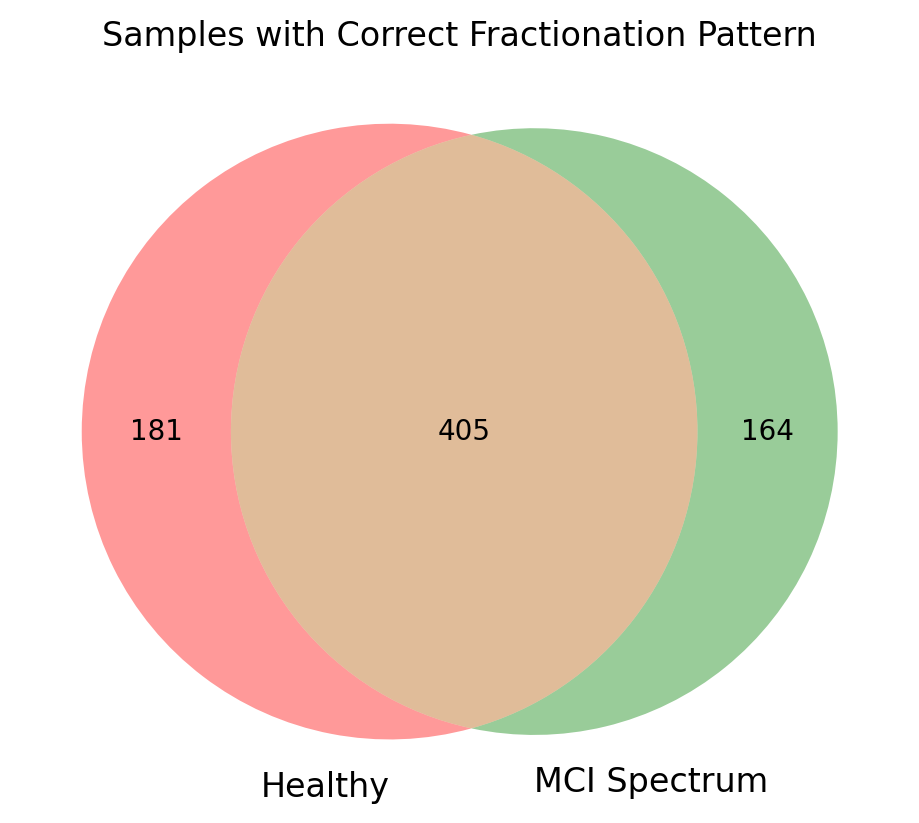

In [691]:
# Healthy vs. MCI spectrum fractionation analysis
healthy_late_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_all_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_early_soluble_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_late_soluble_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

mci_late_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_all_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_early_soluble_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    )
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_late_soluble_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")
    )
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

healthy_fractionation = []
mci_fractionation = []

for assay in list(tidy_data.columns):
    healthy_late_ev_median = healthy_late_ev_fractions[assay].median()
    healthy_all_ev_median = healthy_all_ev_fractions[assay].median()
    healthy_early_soluble_median = healthy_early_soluble_fractions[assay].median()
    healthy_late_soluble_median = healthy_late_soluble_fractions[assay].median()

    mci_late_ev_median = late_ev_fractions[assay].median()
    mci_all_ev_median = all_ev_fractions[assay].median()
    mci_early_soluble_median = early_soluble_fractions[assay].median()
    mci_late_soluble_median = late_soluble_fractions[assay].median()

    if (
        (healthy_late_ev_median > healthy_early_soluble_median)
        and (healthy_all_ev_median > healthy_late_soluble_median)
    ) or (
        (healthy_all_ev_median > healthy_early_soluble_median)
        and (healthy_late_ev_median > healthy_late_soluble_median)
    ):
        healthy_fractionation.append(assay)

    if (
        (mci_late_ev_median > mci_early_soluble_median)
        and (mci_all_ev_median > mci_late_soluble_median)
    ) or (
        (mci_all_ev_median > mci_early_soluble_median)
        and (mci_late_ev_median > mci_late_soluble_median)
    ):
        mci_fractionation.append(assay)

venn2(
    [set(healthy_fractionation), set(mci_fractionation)],
    set_labels=("Healthy", "MCI Spectrum"),
)
plt.title("Samples with Correct Fractionation Pattern")
plt.show()

In [626]:
# All samples fractionation analysis
late_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

all_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

early_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
]

late_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")
]

# Mean v. Median Comparison
mean_assays = []
median_assays = []

for assay in list(tidy_data.columns):
    late_ev_median = late_ev_fractions[assay].median()
    all_ev_median = all_ev_fractions[assay].median()
    early_soluble_median = early_soluble_fractions[assay].median()
    late_soluble_median = late_soluble_fractions[assay].median()

    late_ev_mean = late_ev_fractions[assay].mean()
    all_ev_mean = all_ev_fractions[assay].mean()
    early_soluble_mean = early_soluble_fractions[assay].mean()
    late_soluble_mean = late_soluble_fractions[assay].mean()

    if ((late_ev_mean > early_soluble_mean) and (all_ev_mean > late_soluble_mean)) or (
        (all_ev_mean > early_soluble_mean) and (late_ev_mean > late_soluble_mean)
    ):
        mean_assays.append(assay)
    if (
        (late_ev_median > early_soluble_median)
        and (all_ev_median > late_soluble_median)
    ) or (
        (all_ev_median > early_soluble_median)
        and (late_ev_median > late_soluble_median)
    ):
        median_assays.append(assay)

# venn2(
#     [set(mean_assays), set(median_assays)],
#     set_labels=("Mean", "Median"),
# )

# plt.show()

# T-Test

6 and 7 vs. 11 and 12 vs. 9 and 10-- want 9 and 10 to be higher than everything else (except for late soluble fractions 14/15)

9 and 10 greater than 6, 7, 11, 12 (maybe 8)
stat sig test that says 9 is greater than 11 and 7, 10 is greater than 11 and 7

matched pairs test-- do we care if the median meets the criteria, or that all the individual samples meet the criteria?

does separation between fractions 9 and 10 differ in people with and without alzheimer's? (differences and differences test)
is the 9 and 10 peak true in both the cohorts, or just in 1? we only care about the ones where there is no difference (if the EV peak disappears in AD/MCI patients then it would not be a good target)

if you were looking for which biomarkers are helpful for rpedicting alzheimers, then you would want to correct for 3072 targets
we want to targue that 0/3072 targets are different in people with and without alzheimer's -- bon ferroni correction 
our goal is to ID both TM and int targets that can be useful in the analysis of EVs, we want ot find one that is not different in people with and without alzheimer's-- these are the targets we found, overlaid on DB to see which are cell-type specific

of targets with an early peak, what percentage are TM/internal?
of targets that are TM/internal, what percentage have an early peak?

# make the figures in different ways-- generate a bunch of graphs as if we are doing it based on what Maia wrote and also other ways


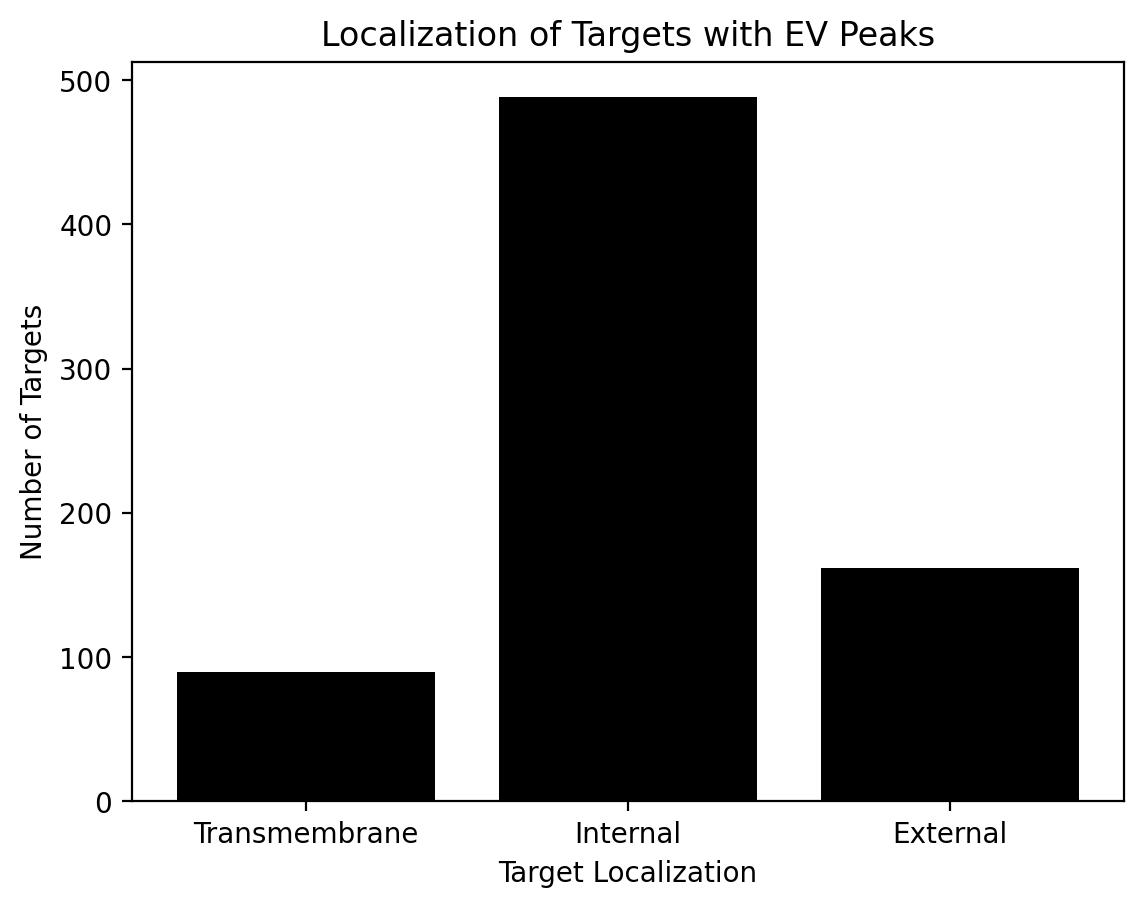

In [656]:
tm_peak = set(all_tm) & set(median_assays)
internal_peak = set(all_inside) & set(median_assays)
external_peak = set(all_outside) & set(median_assays)

peak_dict = {
    "Transmembrane": len(tm_peak),
    "Internal": len(internal_peak),
    "External": len(external_peak),
}

x_labels = list(peak_dict.keys())
y_labels = list(peak_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Target Localization")
plt.ylabel("Number of Targets")
plt.title("Localization of Targets with EV Peaks")
plt.show()

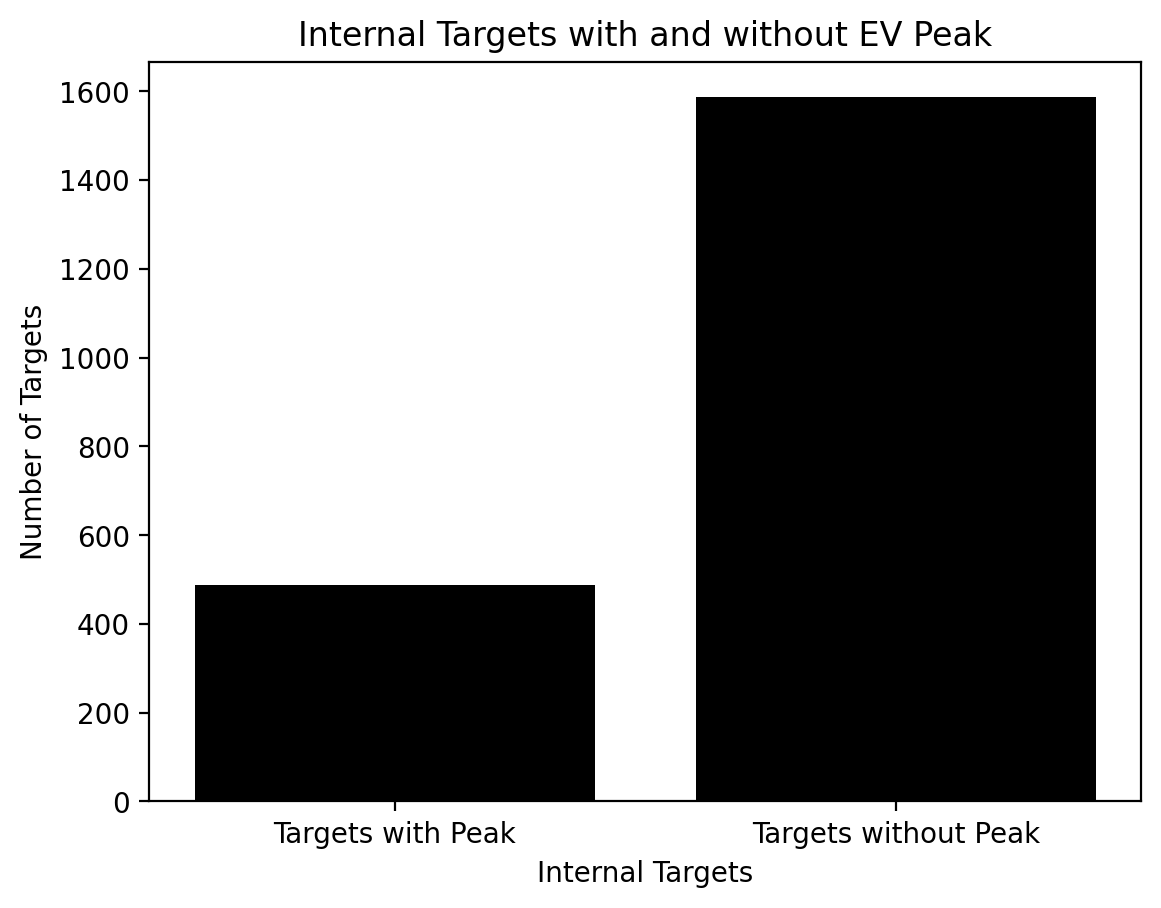

In [660]:
internal_with_peak = set(all_inside) & set(median_assays)
internal_without_peak = set(all_inside) - set(median_assays)

int_dict = {
    "Targets with Peak": len(internal_with_peak),
    "Targets without Peak": len(internal_without_peak),
}

x_labels = list(int_dict.keys())
y_labels = list(int_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Internal Targets")
plt.ylabel("Number of Targets")
plt.title("Internal Targets with and without EV Peak")
plt.show()

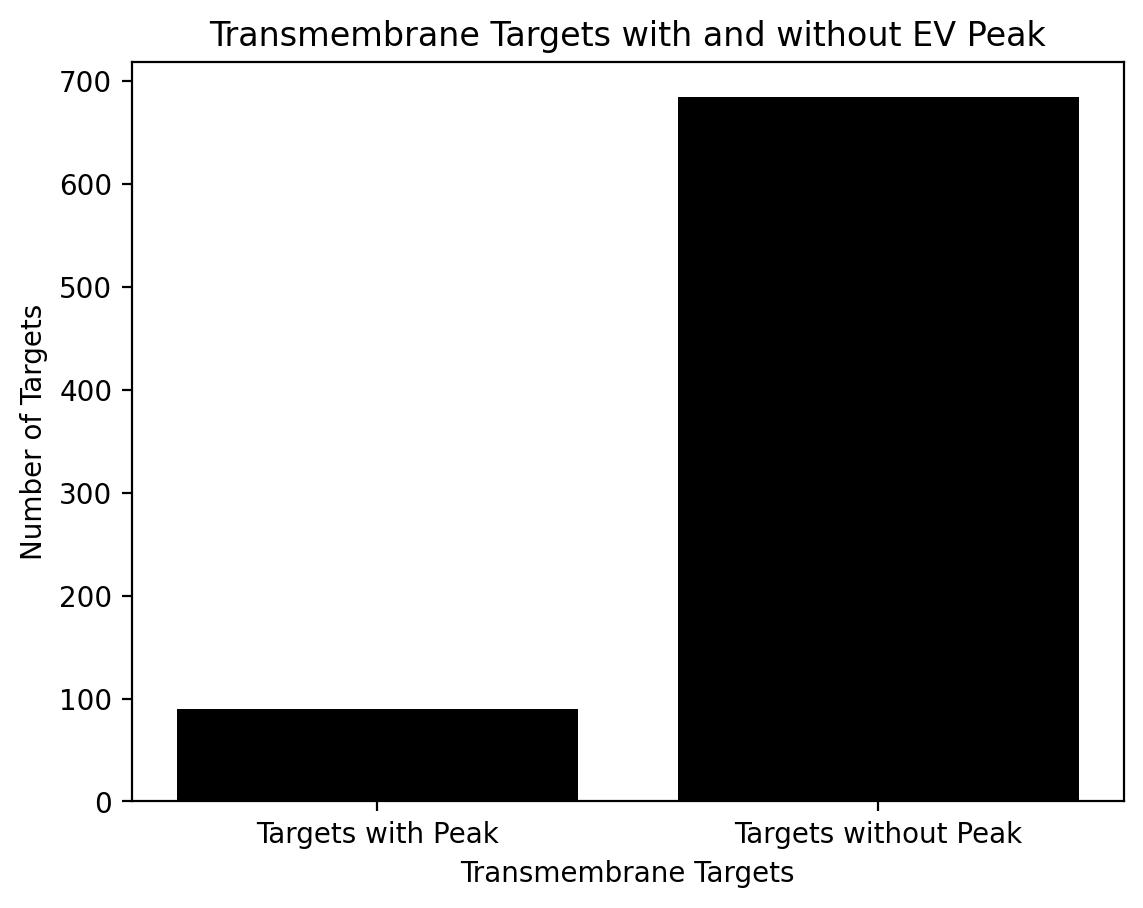

In [652]:
tm_with_peak = set(all_tm) & set(median_assays)
tm_without_peak = set(all_tm) - set(median_assays)

tm_dict = {
    "Targets with Peak": len(tm_with_peak),
    "Targets without Peak": len(tm_without_peak),
}

x_labels = list(tm_dict.keys())
y_labels = list(tm_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets with and without EV Peak")
plt.show()

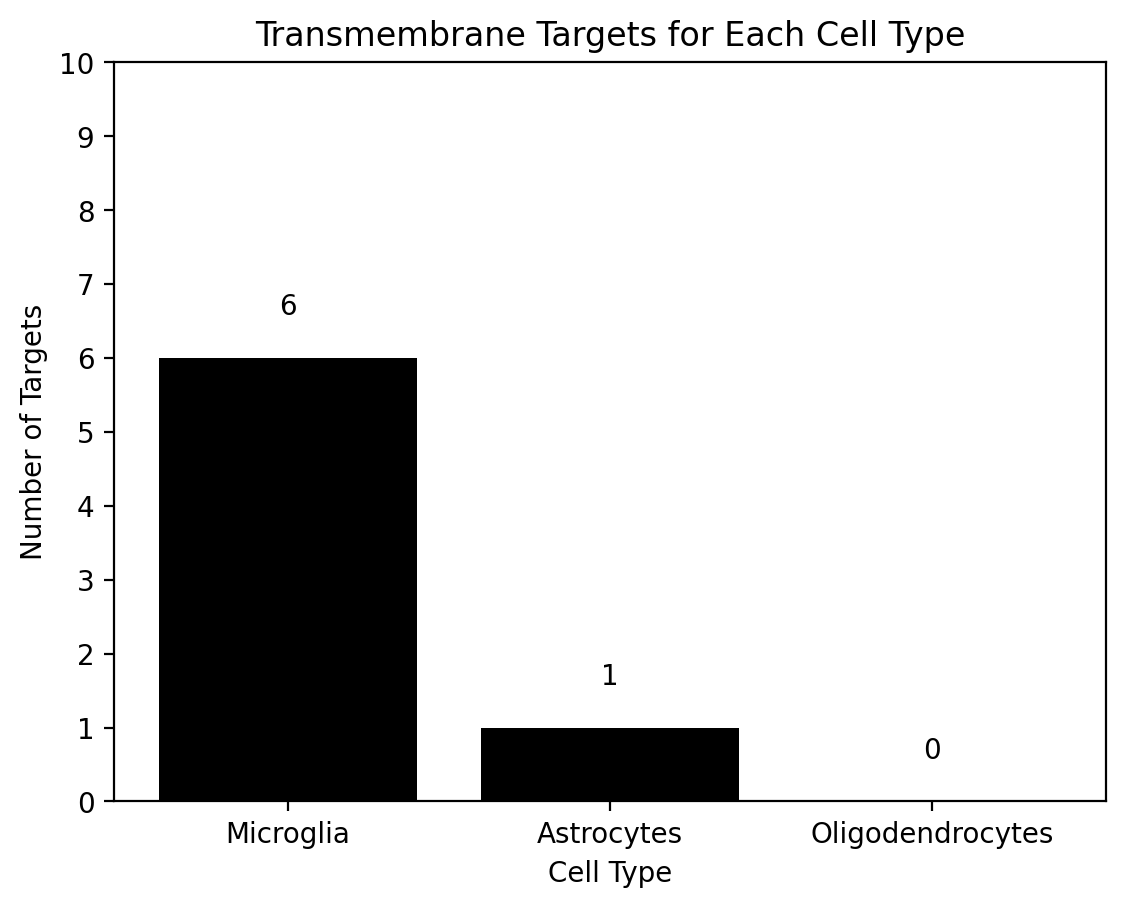

In [689]:
# Overlap between median assays, brain rna seq, and transmembrane targets

# TM microglia
tm_microglia_targets = set(median_assays) & set(microglia_uniprot_ids) & set(all_tm)

# TM astrocyte
tm_astrocyte_targets = (
    set(median_assays) & set(mature_astrocyte_uniprot_ids) & set(all_tm)
)

# TM oligodendrocyte
tm_oligodendrocyte_targets = (
    set(median_assays) & set(oligodendrocyte_uniprot_ids) & set(all_tm)
)

# number of transmembrane targets per cell type

internal_dict = {
    "Microglia": len(tm_microglia_targets),
    "Astrocytes": len(tm_astrocyte_targets),
    "Oligodendrocytes": len(tm_oligodendrocyte_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets for Each Cell Type")
plt.show()

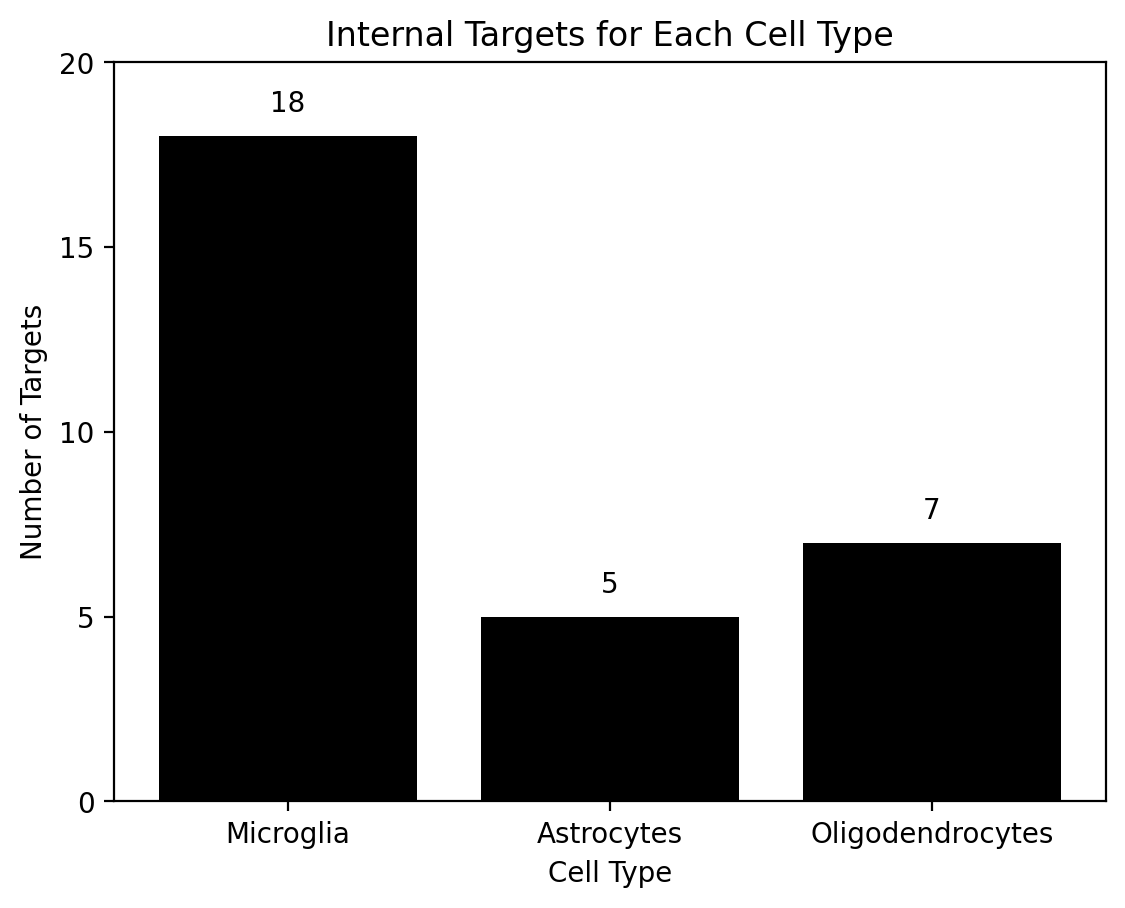

In [688]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_only_microglia_targets = (
    set(median_assays) & set(microglia_uniprot_ids) & set(inside_only_uniprots)
)

# Internal astrocyte
internal_only_astrocyte_targets = (
    set(median_assays) & set(mature_astrocyte_uniprot_ids) & set(inside_only_uniprots)
)

# Internal oligodendrocyte
internal_only_oligodendrocyte_targets = (
    set(median_assays) & set(oligodendrocyte_uniprot_ids) & set(inside_only_uniprots)
)

# number of internal targets per cell type

internal_dict = {
    "Microglia": len(internal_only_microglia_targets),
    "Astrocytes": len(internal_only_astrocyte_targets),
    "Oligodendrocytes": len(internal_only_oligodendrocyte_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([0, 5, 10, 15, 20])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Internal Targets for Each Cell Type")
plt.show()

In [662]:
def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()

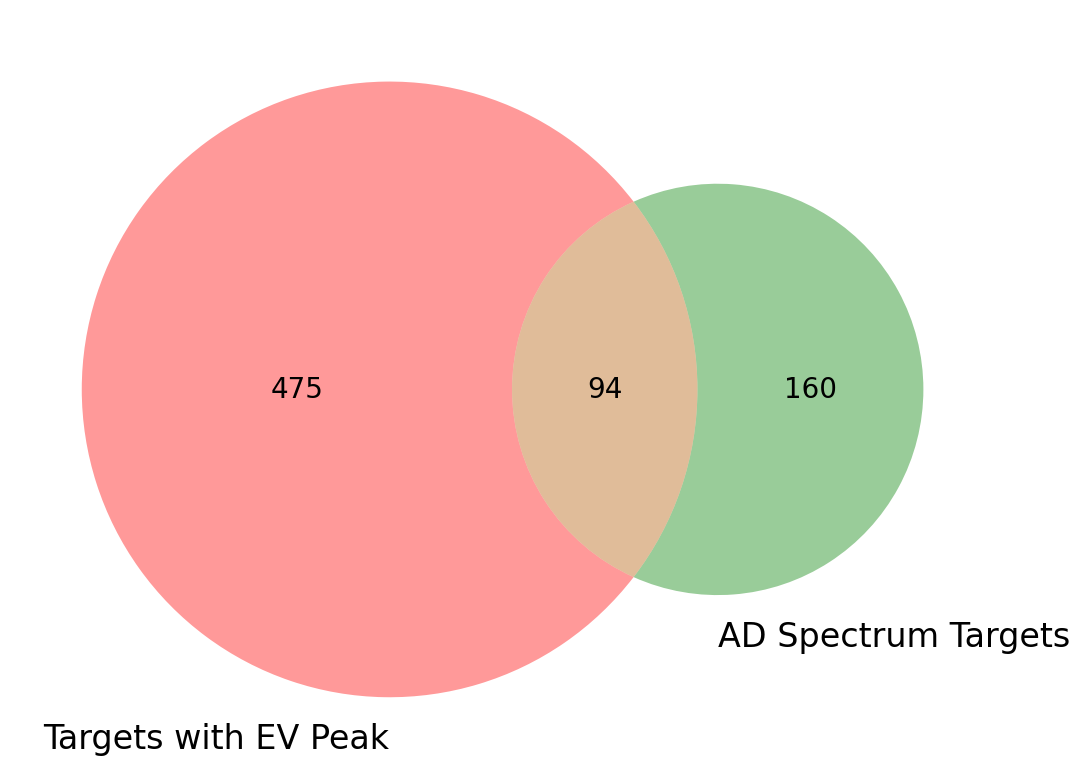

In [687]:
venn2(
    [set(median_assays), set(sig_targets)],
    set_labels=("Targets with EV Peak", "AD Spectrum Targets"),
)

plt.show()